# Mean-field Variational Inference for a Mixture of Gaussians

We implement mean-field variational inference for detecting the centers of a specified number of clusters based on a Gaussian mixture model. Work done by Rachel Levanger for Fall 2016 Foundation of Graphical Models at Columbia University, HW #3.

In [3]:
import math
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

## Some functions we'll use later

In [4]:
# Randomly choose num_clusters points according to N(0,variance*I) distribution in R^dims
def get_cluster_means(num_clusters, variance, dims):
    multi_v_sample = np.random.multivariate_normal(np.zeros(dims), variance*np.identity(dims) , num_clusters).T
    return multi_v_sample

## Generate the sample dataset

We specify K clusters and randomly select their means from a Gaussian distribution centered at zero with high variance (to spread them out). We then randomly choose a membership according to a uniform distribution for each datapoint, then generate that datpoint's position according to a multivariate normal distribution centered at the selected mean with some pre-specified variance common to all clusters.

In [5]:
# Dimension of ambient space
dim = 2

# Set the number of clusters
K = 5

# Set the variance of the distribution of means
p_lambda = 8.

mu_actual = get_cluster_means(K, math.pow(p_lambda,2), dim)

### Generate the sample data according to the generated means of the Gaussian mixture

In [6]:
# Set the number of datapoints in the sample
N = 500

# Set the variance of each of the clusters
sigma = 1.3

# Initialize the dataset
X=np.zeros((N,dim))

# Loop through each datapoint and assign it to a cluster, then generate its position
for n in range(N):
    k = np.random.choice(K)
    X[n,:] = np.random.multivariate_normal(mu_actual[:,k], math.pow(sigma,2)*np.identity(dim), 1)

### Plot the sample data and the means

(-25.0, 5.0, -20.0, 15.0)

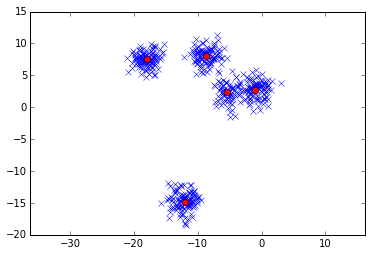

In [7]:
# Plot the means
plt.plot(X[:,0], X[:,1], 'x', markerfacecolor='blue')
plt.plot(mu_actual[0,:], mu_actual[1,:], 'x', marker='o', markerfacecolor='red')
plt.axis('equal')

## Implement mean-field variational inference

### Initialize the algorithm

In [8]:
# Set the minimum number of iterations
iterations = 20

# Set the prior parameters
p_sigma = 2. # Variance of cluster of means

# Initialize the variational parameters
vi_m = np.zeros((iterations, K, dim)) # Cluster means, initialized to random points.
vi_m[0,:,:] = get_cluster_means(K, math.pow(p_sigma,2), dim).T

vi_s_2 = np.zeros((iterations, K)) # Cluster variances, first initialized to one.
vi_s_2[0,:] = np.ones(K)

vi_phi = np.zeros((iterations, N, K)) # Assignment distributions, first initialized to categorical uniform
vi_phi[0,:,:] = np.ones((N,K))*(1./K)

# ELBO table
ELBO = np.zeros(iterations-1)

### Iterate the CAVI algorithm to get variational estimator for posterior

In [9]:

# Iterate the CAVI algorithm
for t in range(1,iterations):
    
    # Update the vi_phi: posterior assignment distributions
    for n in range(N):
        
        for k in range(K):
            log_sum_exp_argument = [np.dot(X[n],vi_m[t-1,j,:]) - (dim*vi_s_2[t-1,j] + np.dot(vi_m[t-1,j,:],vi_m[t-1,j,:]))/2. for j in range(K)]
            max_log_sum_exp = max(log_sum_exp_argument)
            log_sum_exp_sum = sum([math.exp(x - max_log_sum_exp) for x in log_sum_exp_argument])
            vi_phi_log = np.dot(X[n],vi_m[t-1,k,:]) - (dim*vi_s_2[t-1,k] + np.dot(vi_m[t-1,k],vi_m[t-1,k]))/2. - max_log_sum_exp - math.log(log_sum_exp_sum)
            vi_phi[t,n,k] = math.exp(vi_phi_log)
        
    # Update the vi_m and vi_s_2: posterior means and variances 
    vi_m[t,:,:] = vi_m[t-1,:,:]
    for k in range(K):
        
        sum_phi_x = np.zeros(dim)
        for n in range(N):
            sum_phi_x = sum_phi_x + vi_phi[t,n,k]*X[n]
        vi_m[t,k] = (sum_phi_x)/(p_sigma**(-2) + sum(vi_phi[t,:,k]))
        vi_s_2[t,k] = 1./(p_sigma**(-2) + sum(vi_phi[t,:,k]))
    
    # Update the ELBO
    for k in range(K):
        ELBO[t-1] = ELBO[t-1] + (-1./2.)*math.log(2*math.pi*(p_sigma**2)) - (np.dot(vi_m[t,k],vi_m[t,k]) + dim*vi_s_2[t,k])/(2.*p_sigma**2)
        ELBO[t-1] = ELBO[t-1] + (1./2.)*math.log(2*math.pi*vi_s_2[t,k]) + (1./2.)
    for n in range(N):
        ELBO[t-1] = ELBO[t-1] + math.log(1./K)
        ELBO[t-1] = ELBO[t-1] - sum([vi_phi[t,n,k]*math.log(vi_phi[t,n,k]) for k in range(K)])
        ELBO[t-1] = ELBO[t-1] + sum([vi_phi[t,n,k]*((-1./2.)*math.log(2*math.pi) - np.dot(X[n],X[n])/2. + np.dot(X[n],vi_m[t,k]) - (dim*vi_s_2[t,k] + np.dot(vi_m[t,k],vi_m[t,k]))/2.) for k in range(K)])
    

## Plot the results!

(-25.0, 5.0, -20.0, 15.0)

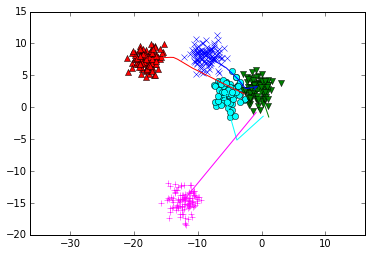

In [10]:

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

color=['cyan', 'blue', 'magenta', 'green', 'red', 'yellow']
marker=['o','x','+','v','^']
# Plot the datapoints with color chosen according to variational distribution
for n in range(N):
    z_n = np.random.multinomial(1,vi_phi[iterations-1,n,:]).nonzero()[0][0]
    ax.plot(X[n,0], X[n,1], 'x', marker=marker[z_n], color=color[z_n])

# Plot the mean history for the variational inference algorithm
for k in range(K):
    ax.plot(vi_m[:,k,0],vi_m[:,k,1], color=color[k])
    circle = matplotlib.patches.Ellipse([vi_m[iterations-1,k,0], vi_m[iterations-1,k,1]], 2.*np.sqrt(vi_s_2[iterations-1,k]), 2.*np.sqrt(vi_s_2[iterations-1,k]), alpha=0.25, color=color[k])
    ax.add_patch(circle)

ax.axis('equal')


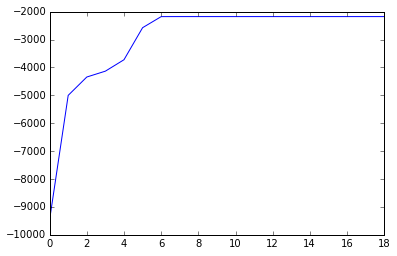

In [11]:
plt.plot(ELBO[:])